La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 110.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importamos las librerias que vamos a necesitar
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
import math 

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
144,0,25.0,52800.0,2,0
2138,0,20.0,46800.0,2,0
1995,0,45.0,41000.0,0,1
3812,1,33.0,20300.0,2,0
1687,0,32.0,32000.0,2,0
1919,1,22.0,32800.0,0,0
2378,1,39.0,32100.0,1,0
3604,0,44.0,43000.0,1,1
1476,1,40.0,34700.0,0,0
3508,0,43.0,46000.0,3,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial
df['age'] = df['age'].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


<AxesSubplot:>

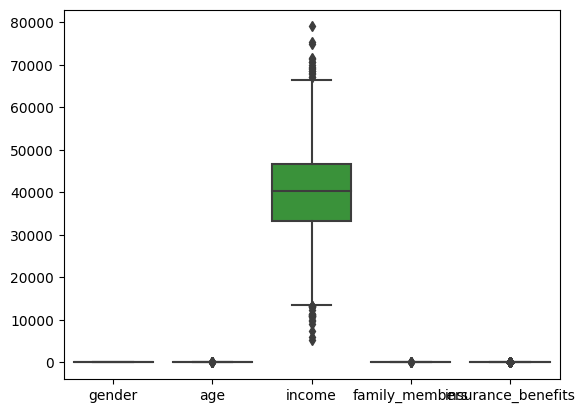

In [10]:
#Veamos la distribución
sns.boxplot(data = df)

array([[<AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'family_members'}>],
       [<AxesSubplot:title={'center':'insurance_benefits'}>,
        <AxesSubplot:>]], dtype=object)

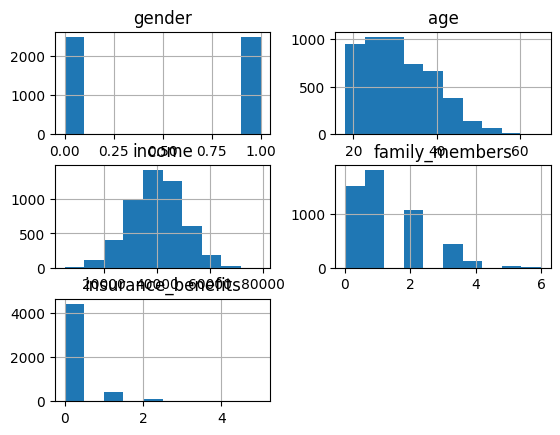

In [11]:
df.hist()

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

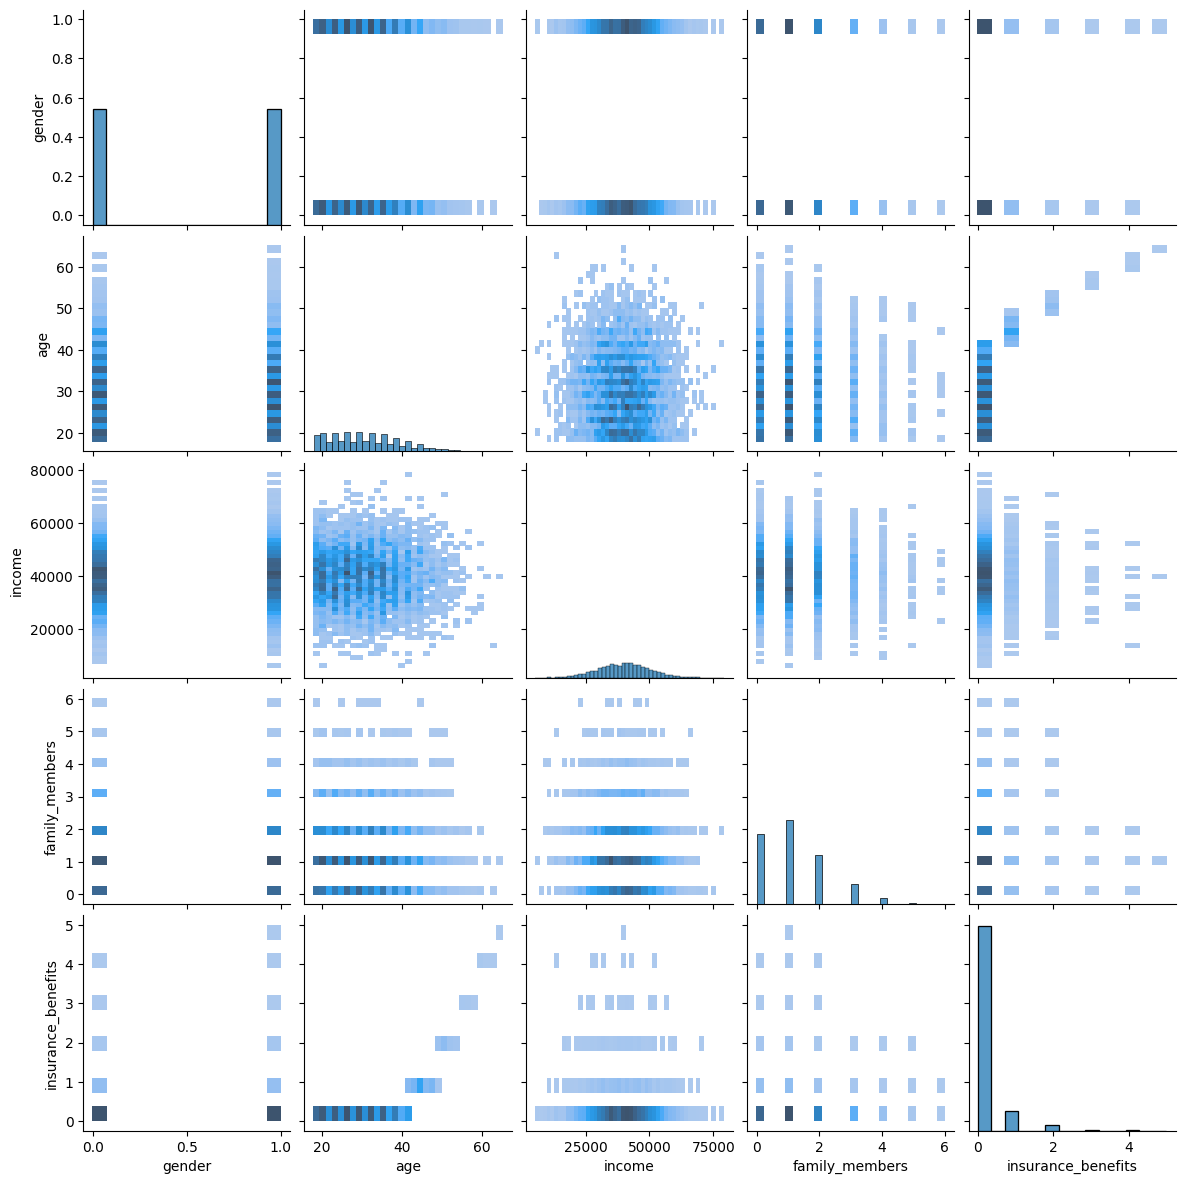

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
#Hacemos nuestra formula para obtener los vecinos mas cercanos kNeighbors 
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [15]:
#Corremos nuestro formula para metricas euclideanas
normal_eucli = get_knn(df, 2, 4 ,'euclidean')
normal_eucli

,gender,age,income,family_members,insurance_benefits,distance
2,0,29,21000.0,0,0,0.00000
4544,1,31,21000.0,1,0,2.44949
2031,0,30,20900.0,0,0,100.00500
1741,1,28,21100.0,0,0,100.01000


In [16]:
#Corremos nuestro formula para metricas manhattan
normal_manhat = get_knn(df, 2, 4 ,'manhattan')
normal_manhat

,gender,age,income,family_members,insurance_benefits,distance
2,0,29,21000.0,0,0,0.0
4544,1,31,21000.0,1,0,4.0
2031,0,30,20900.0,0,0,101.0
1741,1,28,21100.0,0,0,102.0


Escalar datos.

In [17]:
#Guardemos nuestras variables/ columnas a escalar 
feature_names = ['gender', 'age', 'income', 'family_members']

#Guardamos la funcion de transformación
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
#Transformamos nuestros datos ( Escalamos)
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4424,0.0,0.292308,0.596203,0.000000,0
2544,0.0,0.307692,0.570886,0.000000,0
1490,1.0,0.523077,0.682278,0.500000,0
2503,0.0,0.338462,0.441772,0.000000,0
4716,1.0,0.446154,0.560759,0.166667,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [19]:
#Corremos nuestra variable ahora para los datos escalados tanto para euclidean como para manhattan
stand_eucli = get_knn(df, 2, 4 ,'euclidean')
stand_eucli

,gender,age,income,family_members,insurance_benefits,distance
2,0,29,21000.0,0,0,0.00000
4544,1,31,21000.0,1,0,2.44949
2031,0,30,20900.0,0,0,100.00500
1741,1,28,21100.0,0,0,100.01000


In [20]:
stand_manhat = get_knn(df, 2, 4 ,'manhattan')
stand_manhat

,gender,age,income,family_members,insurance_benefits,distance
2,0,29,21000.0,0,0,0.0
4544,1,31,21000.0,1,0,4.0
2031,0,30,20900.0,0,0,101.0
1741,1,28,21100.0,0,0,102.0


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

No, no observamos ninún cambio en los resultados 

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Son muy cercanos los resultados. 

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- 

- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [21]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits']>0)*1
df

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0
...,...,...,...,...,...,...
4995,0,28,35700.0,2,0,0
4996,0,34,52400.0,1,0,0
4997,0,20,33900.0,2,0,0
4998,1,22,32700.0,3,0,0


In [22]:
# comprueba el desequilibrio de clases con value_counts()
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [23]:
#Creamos nuestra formula que  separa los targets y features, entrena, prueba y valida (predice)
def knn_class(df, metric):
    #Separamos nuestros target y features
    features = df.drop(['insurance_benefits_received','insurance_benefits'], axis=1)
    target = df['insurance_benefits_received']
    #Creamos nuestros dataset de entrenamiento y validación
    features_train, features_valid,target_train,target_valid = train_test_split(features, target, random_state=123 , test_size=0.25)

    for k in range(1,11):
        
        nbrs = KNeighborsClassifier(n_neighbors=k, metric=metric)
        nbrs.fit(features_train,target_train)
        l_pred = nbrs.predict(features_valid)
        f1_score = sklearn.metrics.f1_score(target_valid,l_pred)
    #imprimimos nuestro F1 score para evualuar
        print('Valor f1:',f1_score)

In [24]:
print('DF ORIGINAL, DISTANCIA EUCLIDIANA:')
#Corremos nuestra formula y vemos nuestro f1:score para los valores cercanos a predecir
knn_class(df, 'euclidean')

DF ORIGINAL, DISTANCIA EUCLIDIANA:
Valor f1: 0.7413127413127413
Valor f1: 0.45833333333333337
Valor f1: 0.4752475247524752
Valor f1: 0.23312883435582823
Valor f1: 0.27380952380952384
Valor f1: 0.16774193548387095
Valor f1: 0.16774193548387095
Valor f1: 0.06849315068493152
Valor f1: 0.08163265306122448
Valor f1: 0.04166666666666667


In [25]:
#Agremos la columna faltante a los datos escalados 
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits']>0)*1
df_scaled

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1.0,0.630769,0.627848,0.166667,0,0
1,0.0,0.707692,0.481013,0.166667,1,1
2,0.0,0.446154,0.265823,0.000000,0,0
3,0.0,0.323077,0.527848,0.333333,0,0
4,1.0,0.430769,0.330380,0.000000,0,0
...,...,...,...,...,...,...
4995,0.0,0.430769,0.451899,0.333333,0,0
4996,0.0,0.523077,0.663291,0.166667,0,0
4997,0.0,0.307692,0.429114,0.333333,0,0
4998,1.0,0.338462,0.413924,0.500000,0,0


In [26]:
print('DF ESCALADO, DISTANCIA Euclidian:')
#Corremos nuestra formula para los datos escalados 
knn_class(df_scaled, 'euclidean')

DF ESCALADO, DISTANCIA Euclidian:
Valor f1: 0.9534050179211468
Valor f1: 0.928301886792453
Valor f1: 0.9407407407407407
Valor f1: 0.9153846153846154
Valor f1: 0.9104477611940299
Valor f1: 0.9111969111969112
Valor f1: 0.9368029739776951
Valor f1: 0.9398496240601504
Valor f1: 0.9481481481481482
Valor f1: 0.9277566539923954


In [27]:
#Funcion que evalua a nuestro modelo
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [28]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [29]:
#probamos nuestro modelo con diferentes probabilidades
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, df['insurance_benefits'].shape)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [30]:
#Creamos nuestra clase , que en esta caso es para regresión lineal
class MyLinearRegression:
    
    def __init__(self):
        
        #Definimos nuestras
        self.weights = None
        self.w = None 
        self.w0 = None 
    
    def fit(self, X, y):
        #agregamos una constante al entrenamiento, definimos los pesos y las variables w y Wo

        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.w = self.weights[1:]
        self.w0 = self.weights[0]

    def predict(self, X):
        #calculamos el producto escalar y sumamos la variable w0

        #X2 = 
        y_pred = X.dot(self.w) + self.w0
        
        return y_pred

In [31]:
#Creamos nuestra variable para evaluar el modelo con RMSE Y R2 score
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [32]:
#Separamos nuestros features y nuestro objetivo
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

#Creamos el split test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

#Corremos nuestra nueva clase que contiene nuestro modelo 
lr = MyLinearRegression()

#Entrenamos nuestro modelo
lr.fit(X_train, y_train)
#Queremos ver los pesos, asi que imprimos
print('Vector de pesos:', lr.weights)

#Obtenemos y guardamos nuestras predicciones 
y_test_pred = lr.predict(X_test)
#Evaluamos nuestras predicciones
eval_regressor(y_test, y_test_pred)

Vector de pesos: [-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [33]:
#corremos lo mismo pero para los datos escalados 
X_scal = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scal = df_scaled['insurance_benefits'].to_numpy()

X_train_scal, X_test_scal, y_train_scal, y_test_scal = train_test_split(X_scal, y_scal, test_size=0.3, random_state=12345)

lr_scal = MyLinearRegression()

lr_scal.fit(X_train_scal, y_train_scal)
print('Vector de pesos:', lr_scal.weights)

y_test_pred_scal = lr_scal.predict(X_test_scal)
eval_regressor(y_test_scal, y_test_pred_scal)

Vector de pesos: [-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


No observamos diferencias en las métricas de evaluación. Sin embargo, si observamos cambios en los pesos, pero no se traduce en afectaciones al resultado predictivo. 

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [34]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [35]:
#convertimos nuestro df a un array 
X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generar una matriz aleatoria $P$.

In [36]:
#Generamos una matríz aleatoria y la mostramos 
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Comprobar que la matriz P sea invertible

In [37]:
#Invertimos la matríz P y la mostramos 
mat_inv = np.linalg.inv(P)
mat_inv

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [38]:
#Transformamos nuestra matríz y creamos una nueva encriptada
X_t = X @ P
X_t

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

No, porque cada elemento es el producto multiplicado de cada valor. 

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

No, no se puede porque no tienen el mismo tamaño. 

In [39]:
#intentemos revertir nuestra encriptación  
X_o = X_t @ mat_inv
X_o

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Muestra los tres casos para algunos clientes:
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [40]:
print('Original:', X[[0,1,2]])
print()
print('Transformado:', X_t[[0,1,2]])
print()
print('Invertido:', X_o[[0,1,2]])

Original: [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]

Transformado: [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]

Invertido: [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior?

#### Respuesta 

El impacto para el modelo debería ser el mismo. Aunque tienen magnitudes diferentes al ser uno multiplicado por la matríz aleatoria P, la formula compensa esto y lo equilibra. 

¿Cuáles serían los valores predichos con $w_P$? 

#### Respuesta 

Serían valores similares, no en cuanto a valor pero si a equivalencia y rango. Deberían darnos resultados que equiparen a los originales. 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

#### Respuesta 

Esto significa que el RECM debería ser el mismo o muy similar entre los datos ofuscados y los originales. 


No es necesario escribir código en esta sección, basta con una explicación analítica.

**Prueba analítica**

La fórmula nos termina quedando de esta manera 

$$
w_P = I P^{-1} X^{-1} y
$$

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [41]:
# Ya tenemos nuestra matríz aleatoria 
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

In [42]:
#Invertimos nuestra matríz 
P_inv= np.linalg.inv(P)
P_inv

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [43]:
# X_t es nuestra matriz de caracteristicas 
X_t

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

In [44]:
#Para el modelo ya teniamos nuestra función de regresion lineal creada, solo la vamos a adaptar
#para los datos originales ya tenemos nuestros resultados, solo vamos a probar para nuestros datos encriptados
#Vamos a evaluar nuestro modelo 
y_1 = df['insurance_benefits'].to_numpy()

X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_t, y_1, test_size=0.3, random_state=12345)

lr_trans = MyLinearRegression()

lr_trans.fit(X_train_trans, y_train_trans)
print('Vector de pesos:', lr_trans.weights)

pred_trans = lr_trans.predict(X_test_trans)
eval_regressor(y_test_trans, pred_trans)

Vector de pesos: [-0.94353902 -0.05791721 -0.01546567  0.09871889 -0.02397536]
RMSE: 0.34
R2: 0.66


Observo que mis valores predichos SI son distintos pero mis metricas RMSE Y R2 son iguales. Por lo que no podemos decir que la encriptación altera los resultados o las metricas. 

# Conclusiones

Para el proyecto analizamos la información y no encontramos problemas con la información ni requirio mayor corrección. 

Para el caso del modelo de kneighbors que realizamos, no encontramos diferencias entre los datos sin escalar y escalados tanto para la metrica ecludiana y manhattan... anque si encontramos una pequeña variacion dependiendo la metrica que se use. Podemos decir que el escalado no tiene mayor impacto en nuestro modelo. 

Para el modelo de clasificación de vecinos (Kneighbors classifier), aplicado a los datos originales sin escalar y posteriormente a los escalados..encontramos que con los datos escalados encontramos un valor f1 más consistente y elevado (cerca de 1). Por lo que podemos decir que los datos escalados efectivamente mejoran las prediciones de nuestro modelo. 

En el modelo de regresión lineal que realizamos observamos que las metricas RMSE Y R2 son identicos tanto para los datos sin escalar que escalados, pero si observamos que el vector de pesos no es el mismo para ambos pero no parece afectar el resultado. Por lo que tambien podríamos decir que los datos escalados no presentan una mejora en el modelo. 

Observamos que la ofuscación de los datos para el modelo de regresión lineal tampoco afecta los resultados de las metricas, pero al igual que con los datos escalados, observamos que los pesos son distintos pero no presentan problemas para el modelo. 

